In [1]:
import tensorflow as tf
import numpy as np

from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "tf_logs/run-{}".format(now)

In [2]:
he_init = tf.variance_scaling_initializer()

def create_dnn(X , n_hidden , hidden_size , name , training):
    inputs = X
    with tf.variable_scope(name):
        for i in range(n_hidden):
            inputs = tf.layers.dense(inputs , hidden_size, kernel_initializer=he_init , name="hidden{}".format(i+1) , 
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(0.0))
            inputs = tf.layers.batch_normalization(inputs , momentum=0.9 , training=training)
            inputs = tf.nn.elu(inputs)
    return inputs

In [24]:
tf.reset_default_graph()

Xa = tf.placeholder(tf.float32 , shape=(None , 784) , name="Xa")
Xb = tf.placeholder(tf.float32 , shape=(None , 784) , name="Xb")
#X = tf.placeholder(tf.float32 , shape=(None  , 2 , 784) , name="X")
#Xa , Xb = tf.unstack(X , axis = 1)

Y = tf.placeholder(tf.int32 , shape=(None) , name="y")
scale = 0.00
training = tf.placeholder_with_default(False , shape=())

dnn_a = create_dnn(Xa , 5 , 100 , "DNN_A" , training)
dnn_b = create_dnn(Xb , 5 , 100 , "DNN_B" , training)

with tf.name_scope("Merge"):
    combo = tf.concat([dnn_a , dnn_b] , axis=1)
    hiddenlast = tf.layers.dense(combo , 10 , kernel_initializer=he_init , name="hiddenLast" , kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=scale))
    batchLast = tf.layers.batch_normalization(hiddenlast , momentum=0.9 , training=training)
    #batchLast = hiddenlast
    eluLast = tf.nn.elu(batchLast)
    output = tf.layers.dense(eluLast , 1 , name="output" , kernel_initializer=he_init , kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))

y_proba = tf.nn.sigmoid(output)

#baseloss = tf.reduce_mean(tf.square(tf.cast(Y,tf.float32) - y_proba))
baseloss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(Y , tf.float32) , logits=output)
baseloss = tf.reduce_mean(baseloss)
#baseloss = tf.losses.log_loss(tf.cast(Y , tf.float32), y_proba)

loss = tf.add_n([baseloss] + tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

prediction = tf.cast(tf.greater_equal(output, 0), tf.int32)
#prediction = tf.cast(tf.greater(y_proba , 0.5 , name="prediction") , tf.int64)
accuracy = tf.reduce_mean(tf.cast( tf.equal(prediction, Y), tf.float32) , name="accuracy")

acc_summary = tf.summary.scalar("Accuracy" , accuracy)
loss_summary = tf.summary.scalar("Loss" , baseloss)

file_writer = tf.summary.FileWriter(log_dir , tf.get_default_graph())

#optimizer = tf.train.AdamOptimizer(0.00001)
optimizer = tf.train.MomentumOptimizer( 0.001 , momentum=0.95 , use_nesterov=True)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


In [6]:
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data")

In [4]:
#Xt1 = mnist.train.images[:55000]
#yt1 = mnist.train.labels[:55000]

import pandas as pd

data = pd.read_csv("mnist_train.csv")

data.head()
Xt1 = data.drop(columns="label").values
yt1 = data["label"].values

In [5]:
Xm = Xt1[:55000].copy()
ym = yt1[:55000].copy()

In [6]:
def next_batch(step , batch_size):
    global Xm , ym
    start = step * batch_size
    end = start + batch_size
    if end > Xt1.shape[0]:
        start = 0
        end = batch_size
        perm = np.random.permutation(Xt1.shape[0])
        Xm = Xm[perm]
        ym = ym[perm]
    return Xm[start:end] , ym[start:end]

def fetch_data(step , batch_size):
    b1 = next_batch(step , batch_size)
    b2 = next_batch(step + 1, batch_size)
    X , y = (b1[0] , b2[0]) , b1[1] == b2[1]
    return X , y

def fetch_false_data(goal):
    LabelData = list()
    current = 0
    step = 0
    while current < goal:
        data = fetch_data(step , 1)
        step = step + 1
        if data[1] == False:
            LabelData.append(data[0])
            current = current + 1
    return LabelData , np.zeros((goal))
           
def fetch_true_data(seed , goal):
    np.random.seed(seed)
    instanceX = list()
    instancey = list()
    for i in range(10): # for every digit
        digitindicies = (ym == i)
        digitindicies = np.argwhere(digitindicies)
        #print(digitindicies)
        for i in range(goal):
            randidx = np.random.randint(0 , digitindicies.size , 2)
            instanceX.append((Xm[digitindicies[randidx[0]], :] , Xm[digitindicies[randidx[1]] , :]))
            instancey.append(ym[digitindicies[randidx[0]]])        
    return instanceX , np.ones((goal * 10))

def fetch_all_data(num_examples):
    true = num_examples // 2
    true_digit = true // 10
    false = true
    tx , ty = fetch_true_data(42 , true_digit)
    fx , fy = fetch_false_data(false)
    X = tx + fx
    y = np.concatenate([ty , fy])
    X = np.asarray(X)
    perms = np.random.permutation(num_examples)
    X = X[perms]
    y = y[perms]
    return X , y

In [7]:
# coppied from hands on ml

def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [8]:
X , y = fetch_all_data(55000)
subterm = 0

In [9]:
def get_next_batch(step , batch_size):
    global X , y , subterm
    start = step * batch_size
    end = start + batch_size
    start = start - subterm
    end = end - subterm
    if end > X.shape[0]:
        start = 0
        end = batch_size
        perm = np.random.permutation(X.shape[0])
        X = X[perm]
        y = y[perm]
        subterm = subterm + X.shape[0]
    return X[start:end] , y[start:end]

In [10]:
n_epoch = 100
batch_size = 500
num_examples = 55000
n_batches = num_examples // batch_size

n_batches

110

In [25]:
acc_pre = 0

nobenefitsteps = 0
maxnobenefitsteps = 30000

Xbatch , ybatch = get_next_batch(global_step , 2000)

Xa_ = Xbatch[: , 0 , 0 , :]
Xb_ = Xbatch[: , 1 , 0 , :]

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epoch):
        for step in range(n_batches):
            global_step = step + epoch * n_batches
            
            
            #Xbatch , ybatch = generate_batch(Xm , ym , batch_size)
            
            #ybatch = 1 - ybatch
            feed_dict={Xa:Xa_ , Xb:Xb_ , "y:0":ybatch , training:True}
            #feed_dict={X:Xbatch , Y:ybatch , training:True}
            sess.run(training_op , feed_dict=feed_dict)
            acc = sess.run(accuracy , feed_dict={Xa:Xa_ , Xb:Xb_, "y:0":ybatch , training:False})
            acc_sum = acc_summary.eval(feed_dict = {Xa:Xa_ , Xb:Xb_ , "y:0":ybatch , training:False})
            
            #loss_sum = loss_summary.eval(feed_dict = {Xa:Xa_ , Xb:Xb_ , "y:0":ybatch , training:False})
            file_writer.add_summary(acc_sum , global_step)
            #file_writer.add_summary(loss_sum , global_step)
            if acc > acc_pre:
                acc_pre = acc
                saver.save(sess , "/tmp/my_best_model.ckpt")
            else :
                nobenefitsteps = nobenefitsteps + 1 
        print("Epoch : {} | Accuracy : {} | Best : {}".format(epoch , acc , acc_pre))
        if nobenefitsteps > maxnobenefitsteps:
            print("Quitting , {} steps occured with no benefit".format(nobenefitsteps))
            break

Epoch : 0 | Accuracy : nan | Best : 0
Epoch : 1 | Accuracy : nan | Best : 0
Epoch : 2 | Accuracy : nan | Best : 0
Epoch : 3 | Accuracy : nan | Best : 0
Epoch : 4 | Accuracy : nan | Best : 0
Epoch : 5 | Accuracy : nan | Best : 0.5920000076293945
Epoch : 6 | Accuracy : 0.492000013589859 | Best : 0.5920000076293945
Epoch : 7 | Accuracy : 0.515999972820282 | Best : 0.5920000076293945
Epoch : 8 | Accuracy : 0.5659999847412109 | Best : 0.5920000076293945
Epoch : 9 | Accuracy : 0.47999998927116394 | Best : 0.5920000076293945
Epoch : 10 | Accuracy : 0.5239999890327454 | Best : 0.5920000076293945
Epoch : 11 | Accuracy : 0.5120000243186951 | Best : 0.5920000076293945


KeyboardInterrupt: 

In [19]:
output.name
subterm = 0
c , d = get_next_batch(0 , 100)
im1 = c[: , 0 , 0 , :]
im2 = c[: , 1 , 0 , :]

In [20]:
with tf.Session() as sess:
    saver.restore(sess , "/tmp/my_best_model.ckpt")
    results = sess.run(output , feed_dict={Xa:im1 , Xb:im2 , training: False})

INFO:tensorflow:Restoring parameters from /tmp/my_best_model.ckpt


In [21]:
results#.astype(np.int)

array([[-12.046848  ],
       [ -1.2145419 ],
       [ -7.1269965 ],
       [ -4.2245536 ],
       [ -5.864941  ],
       [  1.4134359 ],
       [  5.1296754 ],
       [-10.219156  ],
       [ -4.4659753 ],
       [ -3.062059  ],
       [ -0.6723461 ],
       [ -8.104567  ],
       [ -4.30096   ],
       [-10.554483  ],
       [-20.223383  ],
       [ -1.3918729 ],
       [ -5.853733  ],
       [ -0.9025965 ],
       [  1.181603  ],
       [-10.389662  ],
       [  5.9224296 ],
       [ -5.1455364 ],
       [ -4.0348644 ],
       [ -0.79658365],
       [-13.494886  ],
       [ -8.367344  ],
       [-15.942022  ],
       [ -3.9420428 ],
       [  2.5015607 ],
       [ -5.096929  ],
       [ -2.763115  ],
       [ -3.0678415 ],
       [  0.04795456],
       [ -2.4220595 ],
       [ -6.234724  ],
       [ -1.5280042 ],
       [ -0.3401971 ],
       [-10.492098  ],
       [  4.1069527 ],
       [  0.24385118],
       [-17.209915  ],
       [ -3.6478052 ],
       [ -5.585795  ],
       [-11

In [15]:
import matplotlib.pyplot as plt

def data_checker( t , index):
    X , y = t
    plt.imshow(X[index][0].reshape(28,28))
    plt.show()
    plt.figure()
    plt.imshow(X[index][1].reshape(28,28))
    plt.show()
    print(y[index])
    
z = get_next_batch(0 , 50)

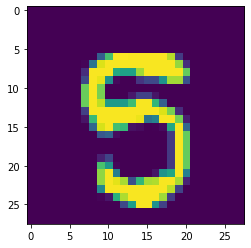

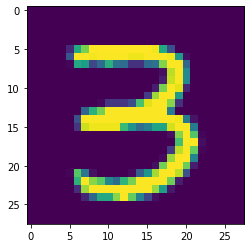

0.0


In [17]:
subterm = 0
data_checker( z , 48)

In [ ]:
Xa

In [ ]:
Xa_.shape

In [ ]:
Xb_.shape

In [ ]:
ybatch.shape

In [ ]:
tf.get_default_graph().get_tensor_by_name("y:0").get_shape()